import relevant libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

part 1:<br>
load_data:Load the dataset (CSV or JSON) using file I/O<br>
preprocess_data:Preprocess cryptocurrency data<br>
select_currencies: Filter data to include only selected currencies<br>
get_available_currencies:Prepare for next step<br>

In [35]:
def load_data(file_path):
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: File does not exist: {file_path}")
        return None
    
    df = pd.read_csv(file_path, low_memory=False)
    
    # Check for required columns
    required_columns = ['symbol', 'date', 'close', 'volume']
    if not all(col in df.columns for col in required_columns):
        print(f"Error: Missing required columns. Required columns: {required_columns}")
        return None
    
    # Display basic dataset information
    print(f"Successfully loaded data with {len(df)} rows and {len(df.columns)} columns.")
    print(f"\nDataset columns: {', '.join(df.columns.tolist())}")
    
    # Display first few rows for reference
    print(f"\nFirst 5 rows:\n{df.head().to_string()}")
    
    return df

In [36]:
def preprocess_data(df):
    # Create a copy to avoid modifying original data
    processed_df = df.copy()
    
    # Convert date column to datetime type
    print("Preprocessing data...")
    processed_df['date'] = pd.to_datetime(processed_df['date'])
    
    # Ensure numerical columns have correct types
    numerical_columns = ['open', 'high', 'low', 'close', 'volume', 'market', 'close_ratio', 'spread']
    for col in numerical_columns:
        if col in processed_df.columns:
            processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
    
    # Count missing values
    print("\nMissing values statistics:")
    missing_values = processed_df.isnull().sum()
    for col, missing in missing_values.items():
        if missing > 0:
            print(f"{col}: {missing}")
    
    # Drop all rows containing NA or missing values
    original_rows = len(processed_df)
    processed_df.dropna(inplace=True)
    deleted_rows = original_rows - len(processed_df)
    print(f"\nDeleted {deleted_rows} rows containing missing values")
    
    # Sort by date
    processed_df.sort_values(['symbol', 'date'], inplace=True)
    
    # Reset index
    processed_df.reset_index(drop=True, inplace=True)
    
    # Display date range
    print(f"\nDate range: {processed_df['date'].min()} to {processed_df['date'].max()}")
    
    # Display row count change
    print(f"Data preprocessing completed, original rows: {original_rows}, processed rows: {len(processed_df)}")
    return processed_df

In [37]:
def select_currencies(df, currencies):
    # Convert currencies to uppercase for case-insensitive matching
    currencies = [curr.upper() for curr in currencies]
    
    # Check if all requested currencies exist in the data
    available_currencies = set(df['symbol'].str.upper())
    not_found = [curr for curr in currencies if curr not in available_currencies]
    
    # Display not found currencies (if any)
    if not_found:
        print(f"Warning: The following currencies were not found in the dataset: {', '.join(not_found)}")
    
    # Filter data
    valid_currencies = [curr for curr in currencies if curr in available_currencies]
    if not valid_currencies:
        print("Error: No requested currencies were found")
        return None
    
    filtered_df = df[df['symbol'].str.upper().isin(valid_currencies)]
    return filtered_df

In [38]:
def get_available_currencies(df):
    return sorted(df['symbol'].unique())

part 2:<br>
calculate_statistics: Calculate statistics for a specific currency<br>
calculate_correlation:Calculate correlation between two cryptocurrencies<br>
get_top_volume_currencies:Get top 5 cryptocurrencies by average trading volume<br>
calculate_volatility:Calculate rolling volatility for a cryptocurrency<br>

In [39]:
def calculate_statistics(df, currency):
    curr_data = df[df['symbol'] == currency].copy()
    if curr_data.empty:
        return None
    
    # Calculate daily returns
    curr_data = curr_data.sort_values('date')
    curr_data['daily_return'] = curr_data['close'].pct_change()
    
    # Calculate statistics
    stats = {
        'currency': currency,
        'name': curr_data['name'].iloc[0] if 'name' in curr_data.columns else 'N/A',
        
        # Close price statistics
        'close_mean': curr_data['close'].mean(),
        'close_median': curr_data['close'].median(),
        'close_std': curr_data['close'].std(),
        
        # Daily return statistics
        'return_mean': curr_data['daily_return'].mean() * 100,  
        'return_median': curr_data['daily_return'].median() * 100,
        'return_std': curr_data['daily_return'].std() * 100,
        
        # Volume statistics
        'volume_mean': curr_data['volume'].mean(),
        'volume_median': curr_data['volume'].median(),
        'volume_std': curr_data['volume'].std(),
        
        # Volatility (using standard deviation of daily returns)
        'volatility': curr_data['daily_return'].std() * np.sqrt(365) * 100  
    }
    
    return stats

In [40]:
def calculate_correlation(df, currency1, currency2):
    # Filter data for two cryptocurrencies
    curr1_data = df[df['symbol'] == currency1].copy()
    curr2_data = df[df['symbol'] == currency2].copy()
    
    if curr1_data.empty or curr2_data.empty:
        return None
    
    # Set date as index
    curr1_data = curr1_data.set_index('date')['close']
    curr2_data = curr2_data.set_index('date')['close']
    
    # Merge data
    combined = pd.DataFrame({
        currency1: curr1_data,
        currency2: curr2_data
    })
    
    # Calculate correlation coefficient
    correlation = combined.corr().iloc[0, 1]
    
    return correlation

In [41]:
def get_top_volume_currencies(df, top_n=5):
    # Calculate average trading volume for each cryptocurrency
    volume_stats = df.groupby('symbol').agg({
        'volume': 'mean',
        'name': 'first'  # Get first name
    }).reset_index()
    
    # Sort by average volume in descending order and select top N
    top_currencies = volume_stats.sort_values('volume', ascending=False).head(top_n)
    
    return top_currencies

In [42]:
def calculate_volatility(df, currency, window=30):
    curr_data = df[df['symbol'] == currency].copy()
    if curr_data.empty:
        return None
    
    # Calculate daily returns
    curr_data = curr_data.sort_values('date')
    curr_data['daily_return'] = curr_data['close'].pct_change()
    
    # Calculate rolling volatility
    curr_data['volatility'] = curr_data['daily_return'].rolling(window=window).std() * np.sqrt(365) * 100
    
    return curr_data[['date', 'volatility']].dropna()

part 3:<br>
plot_closing_prices:Plot closing prices of multiple cryptocurrencies over time<br>
plot_daily_returns:Plot histograms of daily returns<br>
plot_correlation_heatmap:Plot correlation heatmap between different cryptocurrencies<br>
plot_volatility_boxplot:Plot boxplot comparing volatility between different currencies<br>
plot_price_volume_pair:Plot pair plots of price and volume relationships<br>

In [43]:
def plot_closing_prices(df, currencies=None, days=365):
    # Select currencies to plot
    if currencies is None:
        # Default to top 5 currencies by trading volume
        top_currencies = get_top_volume_currencies(df, top_n=5)
        currencies = top_currencies['symbol'].tolist()
    
    # Get recent data
    recent_days = df['date'].max() - pd.Timedelta(days=days)
    recent_data = df[df['date'] >= recent_days]
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    for currency in currencies:
        curr_data = recent_data[recent_data['symbol'] == currency].copy()
        if not curr_data.empty:
            curr_data = curr_data.sort_values('date')
            currency_name = curr_data['name'].iloc[0] if 'name' in curr_data.columns else currency
            plt.plot(curr_data['date'], curr_data['close'], label=f"{currency} ({currency_name})")
    
    plt.title('Cryptocurrency Closing Prices Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Closing Price (USD)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', fontsize=12)
    plt.tight_layout()
    plt.show()

In [44]:
def plot_daily_returns(df, currencies=None, bins=50):
    # Select currencies to plot
    if currencies is None:
        # choose the main 3
        top_currencies = get_top_volume_currencies(df, top_n=3)
        currencies = top_currencies['symbol'].tolist()
    
    # Create figure
    plt.figure(figsize=(14, 10))
    
    # Create subplot
    n_currencies = len(currencies)
    for i, currency in enumerate(currencies, 1):
        curr_data = df[df['symbol'] == currency].copy()
        if not curr_data.empty:
            # Calculate daily returns
            curr_data = curr_data.sort_values('date')
            curr_data['daily_return'] = curr_data['close'].pct_change() * 100  
            
            # Remove NaN values
            daily_returns = curr_data['daily_return'].dropna()
            
            # Plot histogram
            plt.subplot(n_currencies, 1, i)
            sns.histplot(daily_returns, bins=bins, kde=True)
            plt.title(f'{currency} Daily Return Distribution', fontsize=14)
            plt.xlabel('Daily Return (%)', fontsize=12)
            plt.ylabel('Frequency', fontsize=12)
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [45]:
def plot_correlation_heatmap(df, currencies=None, days=365):
    # Select currencies to analyze
    if currencies is None:
        # Default to top 5 currencies by trading volume
        top_currencies = get_top_volume_currencies(df, top_n=5)
        currencies = top_currencies['symbol'].tolist()
    
    # Get recent data
    recent_days = df['date'].max() - pd.Timedelta(days=days)
    recent_data = df[df['date'] >= recent_days]
    
    # Create price pivot table
    pivot_data = recent_data.pivot_table(index='date', columns='symbol', values='close')
    
    # Filter required currencies
    pivot_data = pivot_data[currencies]
    
    # Calculate correlation coefficient matrix
    correlation_matrix = pivot_data.corr()
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, fmt='.3f')
    plt.title('Cryptocurrency Price Correlation Heatmap', fontsize=16)
    plt.tight_layout()
    plt.show()

In [46]:
def plot_volatility_boxplot(df, currencies=None, window=30):
    # Select currencies to analyze
    if currencies is None:
        # Default to top 5 currencies by trading volume
        top_currencies = get_top_volume_currencies(df, top_n=5)
        currencies = top_currencies['symbol'].tolist()
    
    # Collect volatility data and labels for each currency
    data_to_plot = []
    labels = []
    
    for currency in currencies:
        # Calculate volatility directly in the function
        curr_data = df[df['symbol'] == currency].copy()
        
        if not curr_data.empty:
            # Calculate daily returns
            curr_data = curr_data.sort_values('date')
            curr_data['daily_return'] = curr_data['close'].pct_change()
            
            # Calculate rolling volatility
            curr_data['volatility'] = curr_data['daily_return'].rolling(window=window).std() * np.sqrt(365) * 100
            
            # Filter out NaN values
            valid_volatility = curr_data['volatility'].dropna()
            
            if len(valid_volatility) > 0:
                # Store as simple Python list
                data_to_plot.append(valid_volatility.tolist())
                labels.append(currency)
    
    # Draw boxplot if we have data
    if data_to_plot and len(data_to_plot) > 0:
        # Use matplotlib's boxplot to draw directly
        plt.figure(figsize=(14, 8))
        plt.boxplot(data_to_plot, labels=labels)
        plt.title(f'Cryptocurrency {window}-day Rolling Volatility Comparison', fontsize=16)
        plt.xlabel('Cryptocurrency', fontsize=14)
        plt.ylabel('Annualized Volatility (%)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    else:
        print("Error: Insufficient data to draw boxplot")

In [47]:
def plot_price_volume_pair(df, currencies=None, days=365):
    # Select currencies to analyze
    if currencies is None:
        # Default to top 2 currencies by trading volume
        top_currencies = get_top_volume_currencies(df, top_n=2)
        currencies = top_currencies['symbol'].tolist()
    
    # Get recent data
    recent_days = df['date'].max() - pd.Timedelta(days=days)
    recent_data = df[df['date'] >= recent_days]
    
    # Create pair plots for each currency
    for currency in currencies:
        curr_data = recent_data[recent_data['symbol'] == currency].copy()
        if not curr_data.empty:
            currency_name = curr_data['name'].iloc[0] if 'name' in curr_data.columns else currency
            
            # Calculate log price and log volume (better visualization)
            curr_data['log_close'] = np.log(curr_data['close'] + 1)
            curr_data['log_volume'] = np.log(curr_data['volume'] + 1)
            curr_data['daily_return'] = curr_data['close'].pct_change() * 100
            curr_data['log_volume_change'] = np.log(curr_data['volume'].pct_change() + 1)
            
            # Create pair plot
            pair_data = curr_data[['close', 'volume', 'daily_return']].dropna()
            pair_data.columns = ['Price', 'Volume', 'Daily Return']
            
            plt.figure(figsize=(12, 10))
            sns.pairplot(pair_data, diag_kind='kde')
            plt.suptitle(f'{currency} ({currency_name}) Price, Volume and Return Relationship Analysis', y=1.02, fontsize=16)
            plt.tight_layout()
            plt.show()

part 4: (creative part)<br>
generate_trading_signals:Generate trading recommendations based on price and volume relationships<br>
visualize_trading_signals:Visualize trading signals and threshold ranges for a specific currency<br>

In [48]:
def generate_trading_signals(df, currencies=None, window=30, volatility_multiplier=2):
    # Initialize return values
    trading_signals = {}
    
    # Select currencies to analyze
    if currencies is None:
        # still choose 3 main currencies
        top_currencies = get_top_volume_currencies(df, top_n=3)
        if top_currencies is not None and not top_currencies.empty:
            currencies = top_currencies['symbol'].tolist()
        else:
            return trading_signals
    
    # Ensure currencies is a list type
    if not isinstance(currencies, list):
        currencies = [currencies]
    
    for currency in currencies:
        curr_data = df[df['symbol'] == currency].copy()
        if not curr_data.empty:
            curr_data = curr_data.sort_values('date')
            currency_name = curr_data['name'].iloc[0] if 'name' in curr_data.columns else currency
            
            # Calculate daily returns and volume change rate
            curr_data['daily_return'] = curr_data['close'].pct_change() * 100
            curr_data['volume_change'] = curr_data['volume'].pct_change() * 100
            
            # Calculate price-volume correlation (rolling window)
            curr_data['price_volume_corr'] = curr_data['daily_return'].rolling(window=window).corr(curr_data['volume_change'])
            
            # Calculate price volatility
            curr_data['price_volatility'] = curr_data['daily_return'].rolling(window=window).std()
            
            # Build threshold ranges (based on price volatility)
            curr_data['upper_threshold'] = volatility_multiplier * curr_data['price_volatility']
            curr_data['lower_threshold'] = -volatility_multiplier * curr_data['price_volatility']
            
            # Generate trading signals
            signals = []
            for idx, row in curr_data.iterrows():
                signal = 'Hold'
                confidence = 0
                
                if not pd.isna(row['daily_return']) and not pd.isna(row['upper_threshold']) and not pd.isna(row['lower_threshold']):
                    # Large price increase with high volume
                    if row['daily_return'] > row['upper_threshold'] and row['volume_change'] > 20:
                        signal = 'Sell'
                        confidence = 0.8
                    # Large price decrease with high volume
                    elif row['daily_return'] < row['lower_threshold'] and row['volume_change'] > 20:
                        signal = 'Buy'
                        confidence = 0.8
                    # Large price increase with low volume (potential false breakout)
                    elif row['daily_return'] > row['upper_threshold'] and row['volume_change'] < -20:
                        signal = 'Hold'
                        confidence = 0.6
                    # Large price decrease with low volume (potential false decline)
                    elif row['daily_return'] < row['lower_threshold'] and row['volume_change'] < -20:
                        signal = 'Hold'
                        confidence = 0.6
                
                signals.append({
                    'date': row['date'],
                    'price': row['close'],
                    'daily_return': row['daily_return'],
                    'volume': row['volume'],
                    'volume_change': row['volume_change'],
                    'upper_threshold': row['upper_threshold'],
                    'lower_threshold': row['lower_threshold'],
                    'signal': signal,
                    'confidence': confidence
                })
            
            # Get recent trading signals
            if signals:
                latest_signal = signals[-1]
                
                # Analyze price-volume relationship patterns
                recent_signals = signals[-30:] if len(signals) >= 30 else signals
                price_volume_correlation = curr_data['price_volume_corr'].iloc[-1] if not pd.isna(curr_data['price_volume_corr'].iloc[-1]) else 0
                
                pattern_analysis = []
                if price_volume_correlation > 0.3:
                    pattern_analysis.append("Price and volume are positively correlated, trading is active during price increases")
                elif price_volume_correlation < -0.3:
                    pattern_analysis.append("Price and volume are negatively correlated, trading is active during price decreases")
                else:
                    pattern_analysis.append("Weak correlation between price and volume")
                
                # Count recent buy/sell signals
                buy_signals = sum(1 for s in recent_signals if s['signal'] == 'Buy')
                sell_signals = sum(1 for s in recent_signals if s['signal'] == 'Sell')
                
                if buy_signals > sell_signals * 1.5:
                    pattern_analysis.append(f"More buy signals recently ({buy_signals} buys, {sell_signals} sells)")
                elif sell_signals > buy_signals * 1.5:
                    pattern_analysis.append(f"More sell signals recently ({buy_signals} buys, {sell_signals} sells)")
                
                # Save signal information
                trading_signals[currency] = {
                    'currency': currency,
                    'name': currency_name,
                    'latest_price': latest_signal['price'],
                    'latest_volume': latest_signal['volume'],
                    'latest_return': latest_signal['daily_return'],
                    'latest_volume_change': latest_signal['volume_change'],
                    'upper_threshold': latest_signal['upper_threshold'],
                    'lower_threshold': latest_signal['lower_threshold'],
                    'recommended_action': latest_signal['signal'],
                    'confidence': latest_signal['confidence'],
                    'price_volume_correlation': price_volume_correlation,
                    'pattern_analysis': pattern_analysis,
                    'full_signals': signals
                }
    
    return trading_signals

In [49]:
def visualize_trading_signals(trading_signals, currency):
    if currency not in trading_signals:
        print(f"Error: Trading signals not found for currency {currency}")
        return
    
    signal_data = trading_signals[currency]
    signals = signal_data['full_signals']
    
    # Convert to DataFrame for visualization
    signals_df = pd.DataFrame(signals)
    signals_df = signals_df.dropna(subset=['date', 'daily_return', 'upper_threshold', 'lower_threshold'])
    
    # Only show recent 100 data points
    if len(signals_df) > 100:
        signals_df = signals_df.tail(100)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    
    # Top plot: Price returns and threshold ranges
    ax1.plot(signals_df['date'], signals_df['daily_return'], label='Daily Return (%)', color='blue', alpha=0.7)
    ax1.plot(signals_df['date'], signals_df['upper_threshold'], label=f'Upper Threshold', color='red', linestyle='--')
    ax1.plot(signals_df['date'], signals_df['lower_threshold'], label=f'Lower Threshold', color='green', linestyle='--')
    
    # Mark buy and sell signals
    buy_signals = signals_df[signals_df['signal'] == 'Buy']
    sell_signals = signals_df[signals_df['signal'] == 'Sell']
    
    if not buy_signals.empty:
        ax1.scatter(buy_signals['date'], buy_signals['daily_return'], 
                   marker='^', color='green', s=100, label='Buy Signal')
    if not sell_signals.empty:
        ax1.scatter(sell_signals['date'], sell_signals['daily_return'], 
                   marker='v', color='red', s=100, label='Sell Signal')
    
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.set_title(f'{signal_data["currency"]} ({signal_data["name"]}) Trading Signals and Price Volatility Thresholds', fontsize=16)
    ax1.set_ylabel('Daily Return (%)', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best', fontsize=12)
    
    # Bottom plot: Volume changes
    ax2.bar(signals_df['date'], signals_df['volume_change'], alpha=0.5, color='orange')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel('Date', fontsize=14)
    ax2.set_ylabel('Volume Change Rate (%)', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print trading recommendation summary
    print(f"\n=== {signal_data['currency']} ({signal_data['name']}) Trading Recommendation ===")
    print(f"Current Price: ${signal_data['latest_price']:.2f}")
    print(f"Latest Daily Return: {signal_data['latest_return']:.2f}%")
    print(f"Latest Volume Change: {signal_data['latest_volume_change']:.2f}%")
    print(f"\nThreshold Range: [{signal_data['lower_threshold']:.2f}%, {signal_data['upper_threshold']:.2f}%]")
    print(f"\nRecommended Action: {signal_data['recommended_action']} (Confidence: {signal_data['confidence']:.0%})")
    print(f"\nPrice-Volume Correlation: {signal_data['price_volume_correlation']:.3f}")
    print(f"\nPattern Analysis:")
    for pattern in signal_data['pattern_analysis']:
        print(f"  - {pattern}")
    print("""\nAction Explanation:
  • Buy: Large price decrease with high volume, potential bottom buying opportunity
  • Sell: Large price increase with high volume, potential profit-taking opportunity
  • Hold: Price volatility within normal range
  • Hold: Abnormal price movement without volume confirmation, potential false breakout""")

=== Starting Cryptocurrency Data Analysis Program ===

1. Checking file path...
Dataset found: /workspaces/Analysis-of-the-closing-price-time-series-for-the-five-major-cryptocurrencies-BTC-ETH-XRP-LTC-BNB-/crypto-markets.csv

2. Loading data...
Successfully loaded data with 679183 rows and 13 columns.

Dataset columns: slug, symbol, name, date, ranknow, open, high, low, close, volume, market, close_ratio, spread

First 5 rows:
      slug symbol     name        date  ranknow    open    high     low   close  volume      market  close_ratio  spread
0  bitcoin    BTC  Bitcoin  2013-04-28        1  135.30  135.98  132.10  134.21       0  1500520000       0.5438    3.88
1  bitcoin    BTC  Bitcoin  2013-04-29        1  134.44  147.49  134.00  144.54       0  1491160000       0.7813   13.49
2  bitcoin    BTC  Bitcoin  2013-04-30        1  144.00  146.93  134.05  139.00       0  1597780000       0.3843   12.88
3  bitcoin    BTC  Bitcoin  2013-05-01        1  139.00  139.89  107.72  116.99      

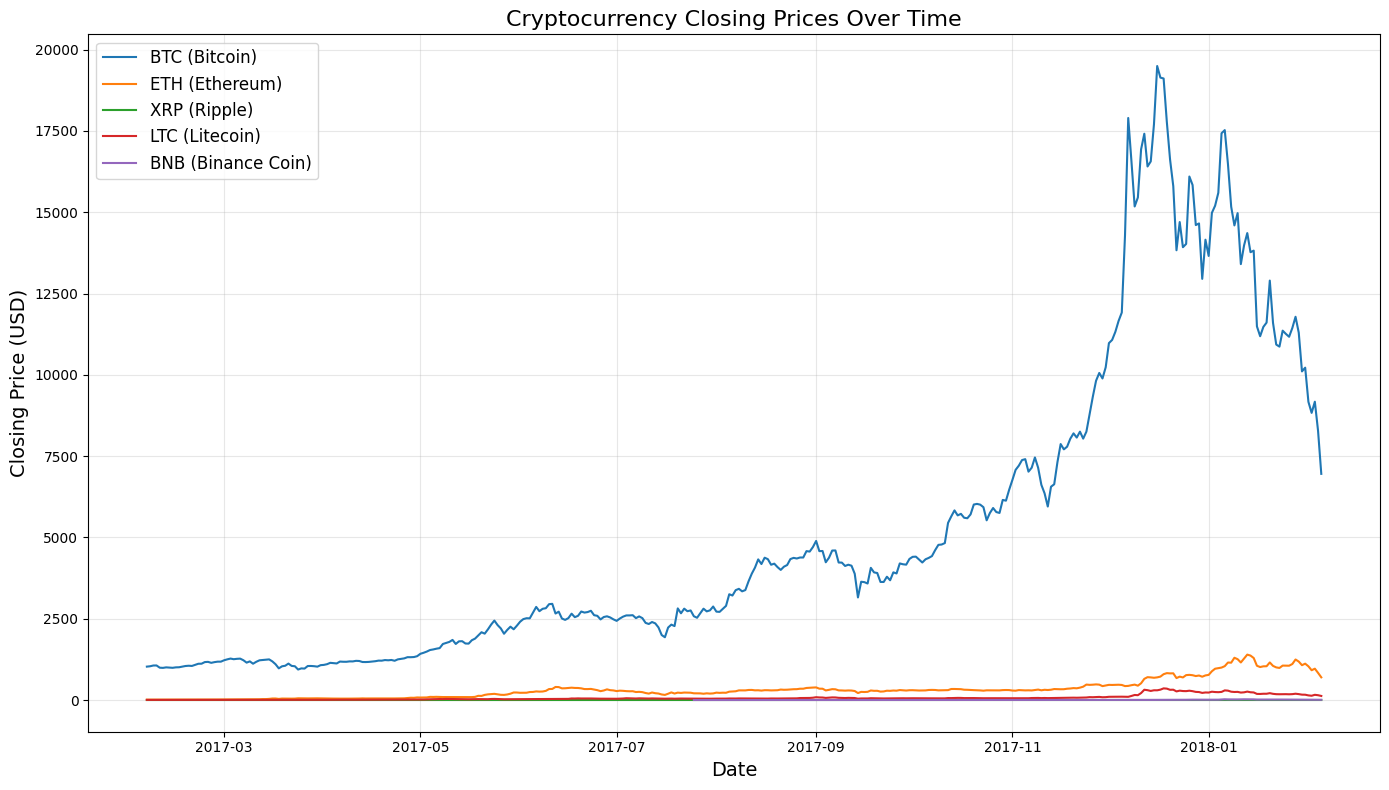

 Closing price line chart generated successfully

9.2 Plotting daily return histograms...


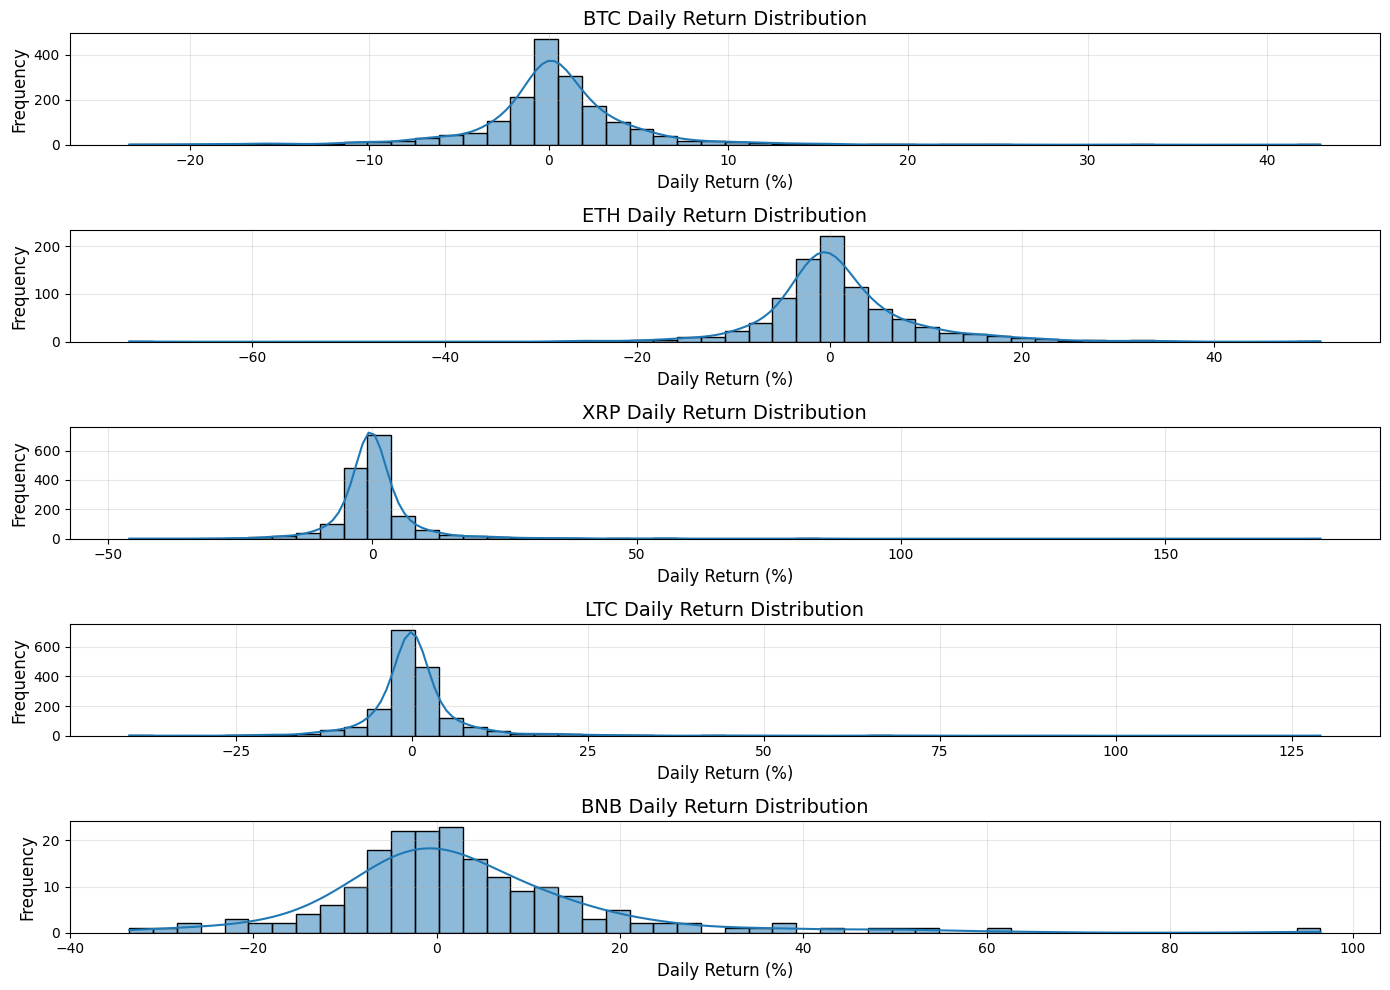

 Daily return histograms generated successfully

9.3 Plotting correlation heatmap...


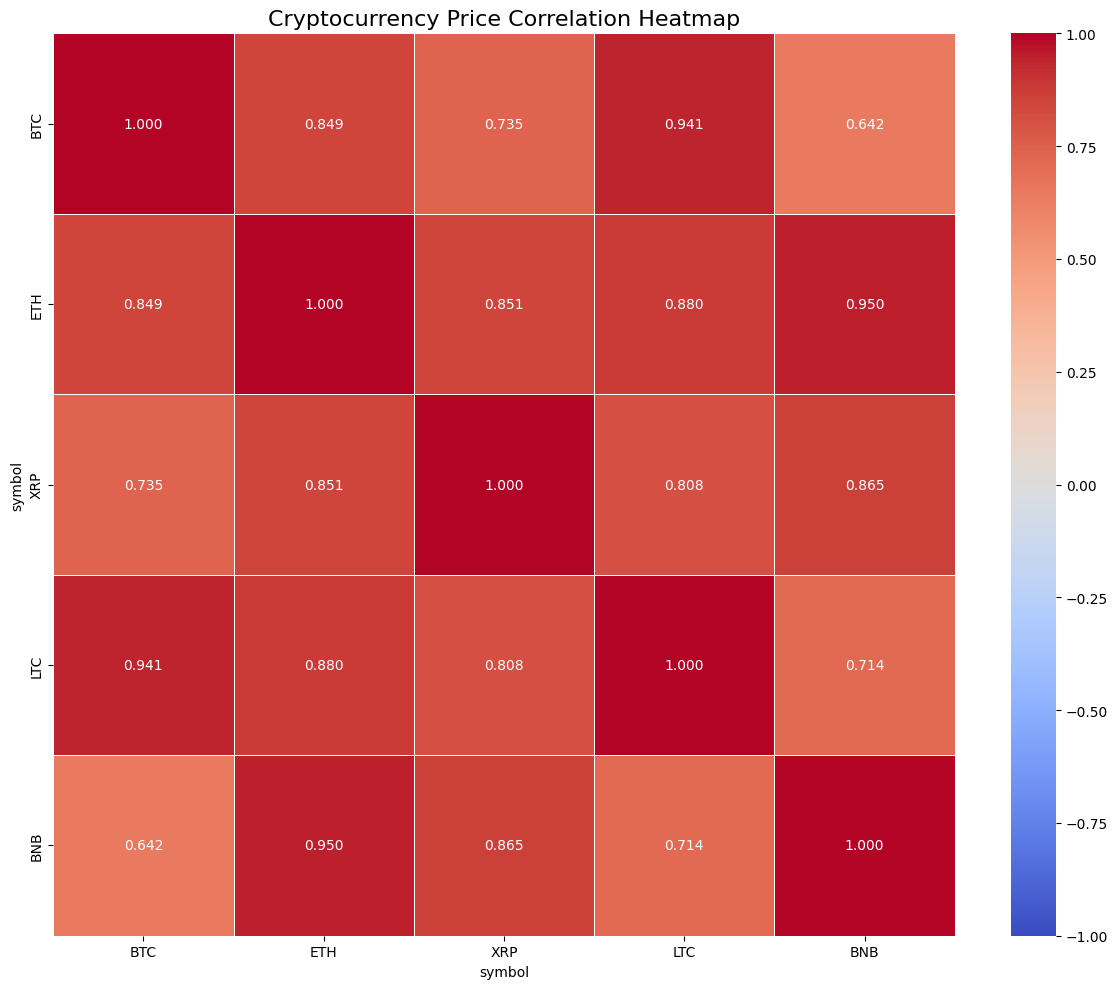

 Correlation heatmap generated successfully

9.4 Plotting volatility boxplot...


/tmp/ipykernel_20860/1842517991.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)


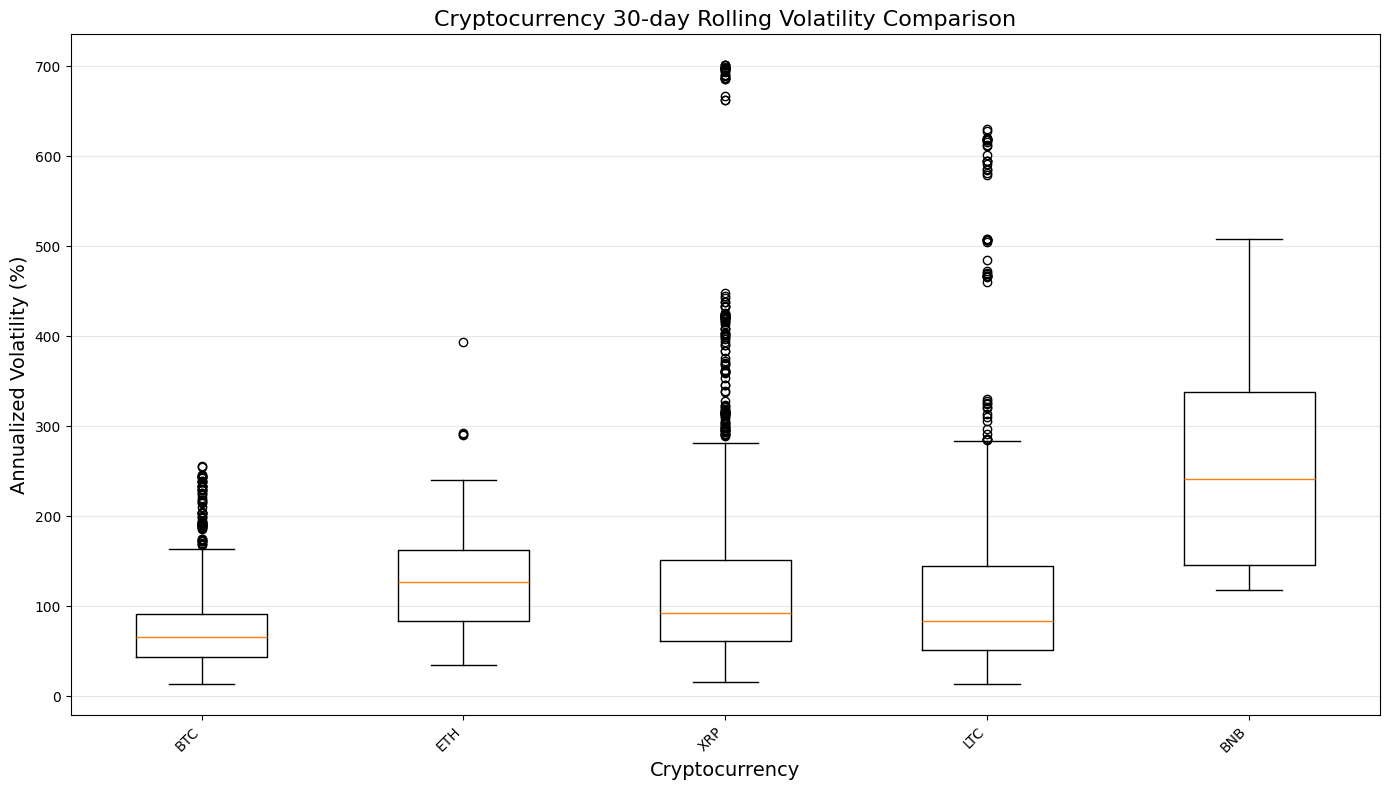

 Volatility boxplot generated successfully

9.5 Plotting price and volume pair plots...


<Figure size 1200x1000 with 0 Axes>

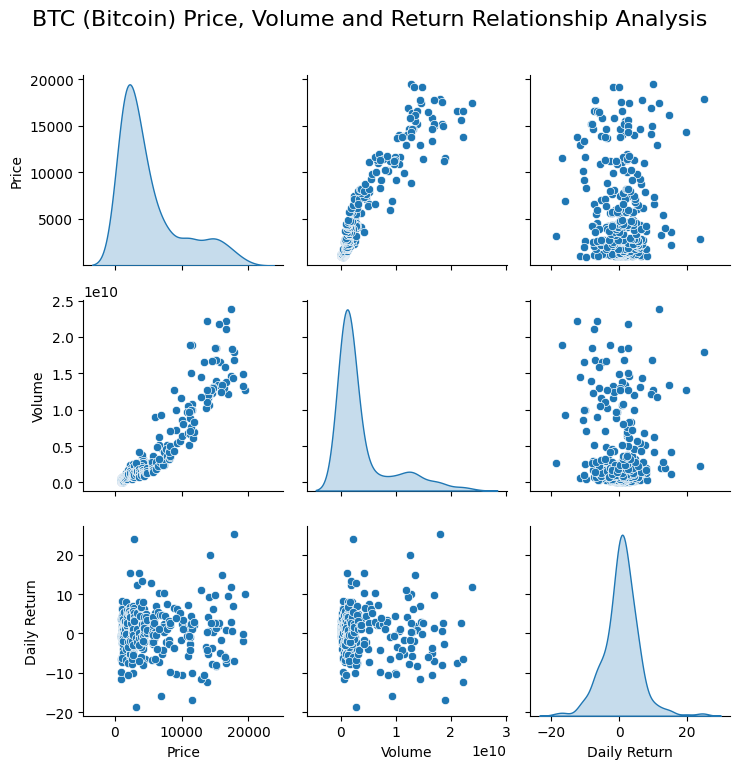

<Figure size 1200x1000 with 0 Axes>

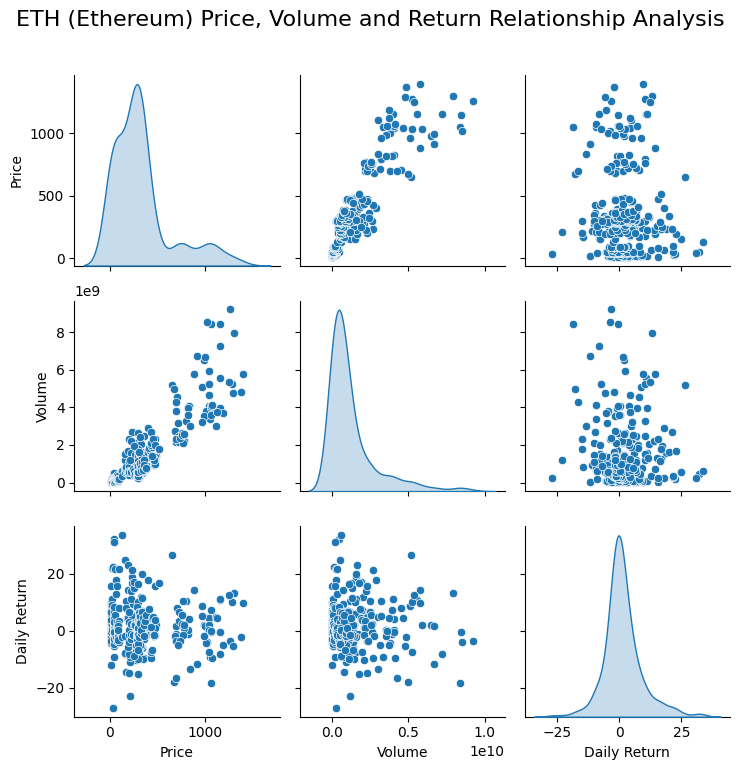

 Price and volume pair plots generated successfully

10. Trading signal analysis based on price and volume relationship...
Analyzing trading signals for: BTC, ETH, XRP
Successfully generated trading signals for 3 currencies


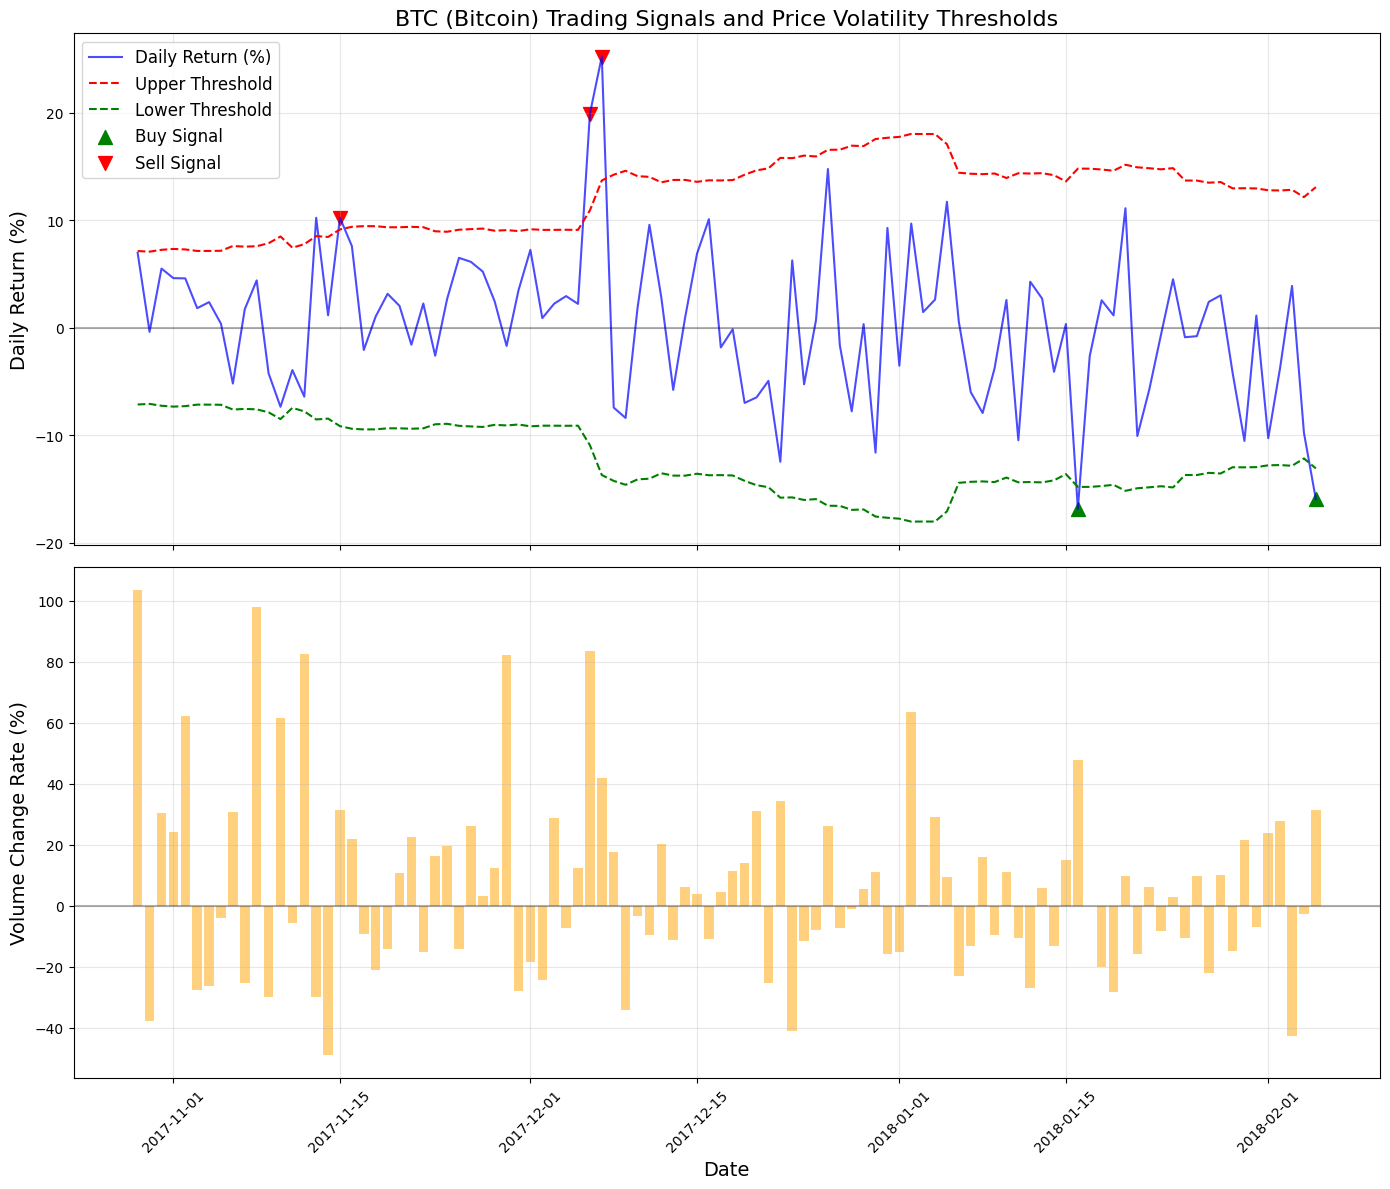


=== BTC (Bitcoin) Trading Recommendation ===
Current Price: $6955.27
Latest Daily Return: -15.97%
Latest Volume Change: 31.27%

Threshold Range: [-13.10%, 13.10%]

Recommended Action: Buy (Confidence: 80%)

Price-Volume Correlation: -0.462

Pattern Analysis:
  - Price and volume are negatively correlated, trading is active during price decreases
  - More buy signals recently (2 buys, 0 sells)

Action Explanation:
  • Buy: Large price decrease with high volume, potential bottom buying opportunity
  • Sell: Large price increase with high volume, potential profit-taking opportunity
  • Hold: Price volatility within normal range
  • Hold: Abnormal price movement without volume confirmation, potential false breakout
 BTC trading signal visualization completed


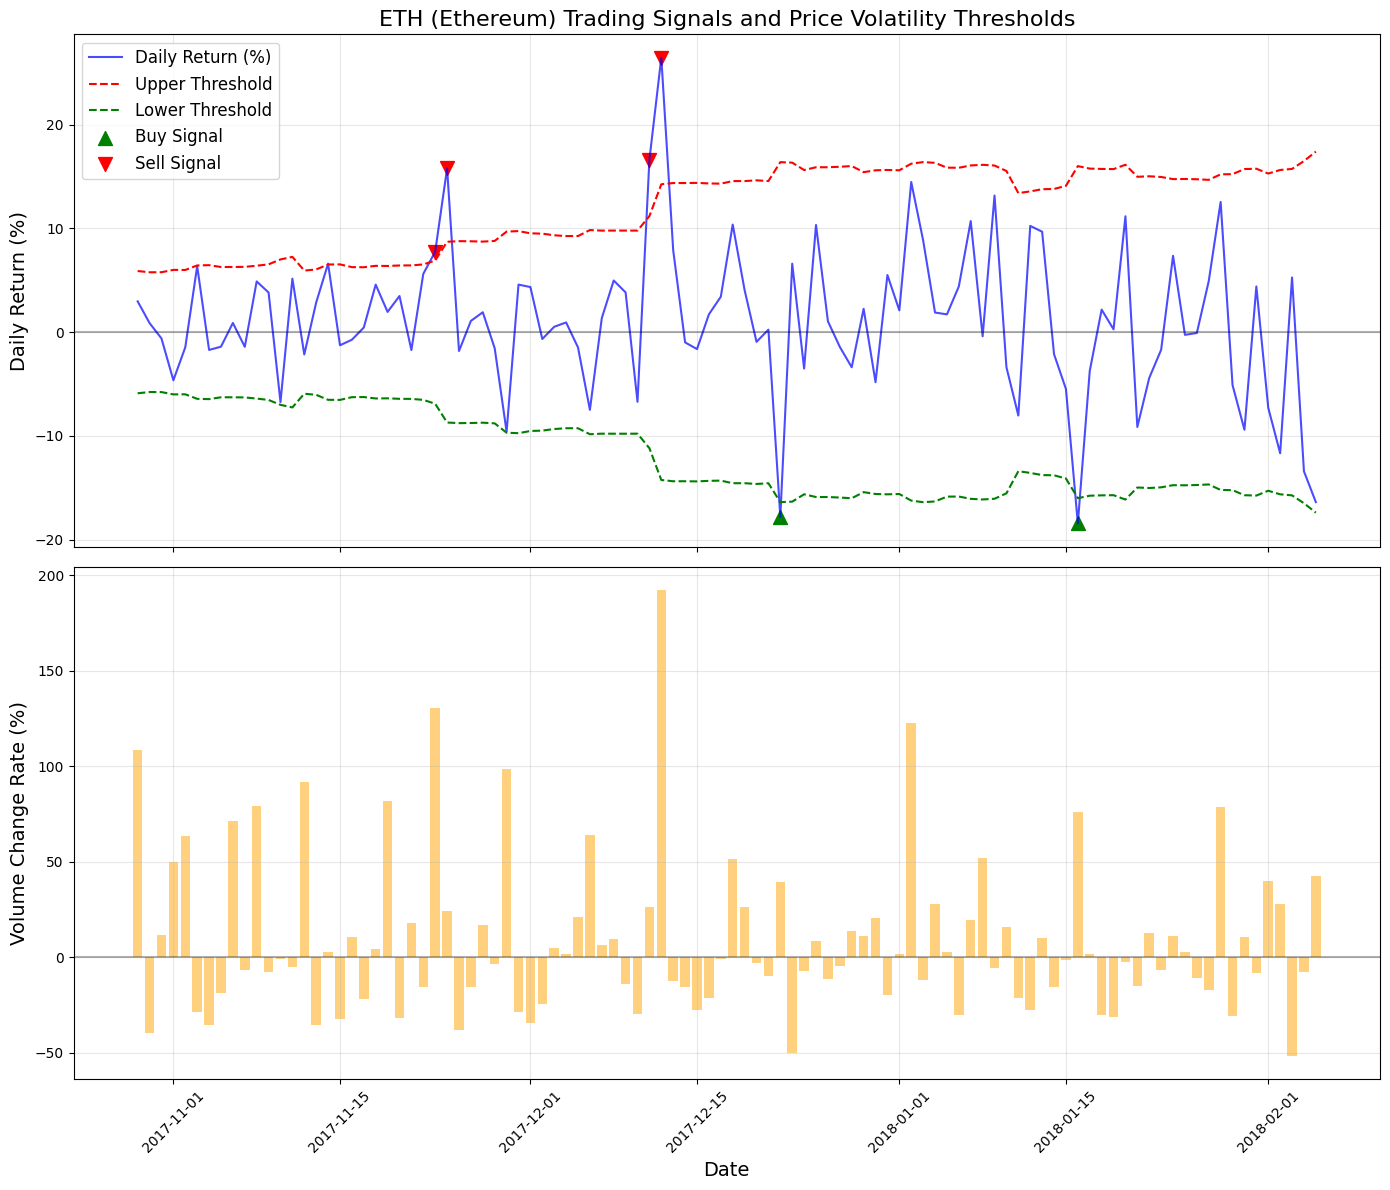


=== ETH (Ethereum) Trading Recommendation ===
Current Price: $697.95
Latest Daily Return: -16.38%
Latest Volume Change: 42.46%

Threshold Range: [-17.40%, 17.40%]

Recommended Action: Hold (Confidence: 0%)

Price-Volume Correlation: -0.219

Pattern Analysis:
  - Weak correlation between price and volume
  - More buy signals recently (1 buys, 0 sells)

Action Explanation:
  • Buy: Large price decrease with high volume, potential bottom buying opportunity
  • Sell: Large price increase with high volume, potential profit-taking opportunity
  • Hold: Price volatility within normal range
  • Hold: Abnormal price movement without volume confirmation, potential false breakout
 ETH trading signal visualization completed


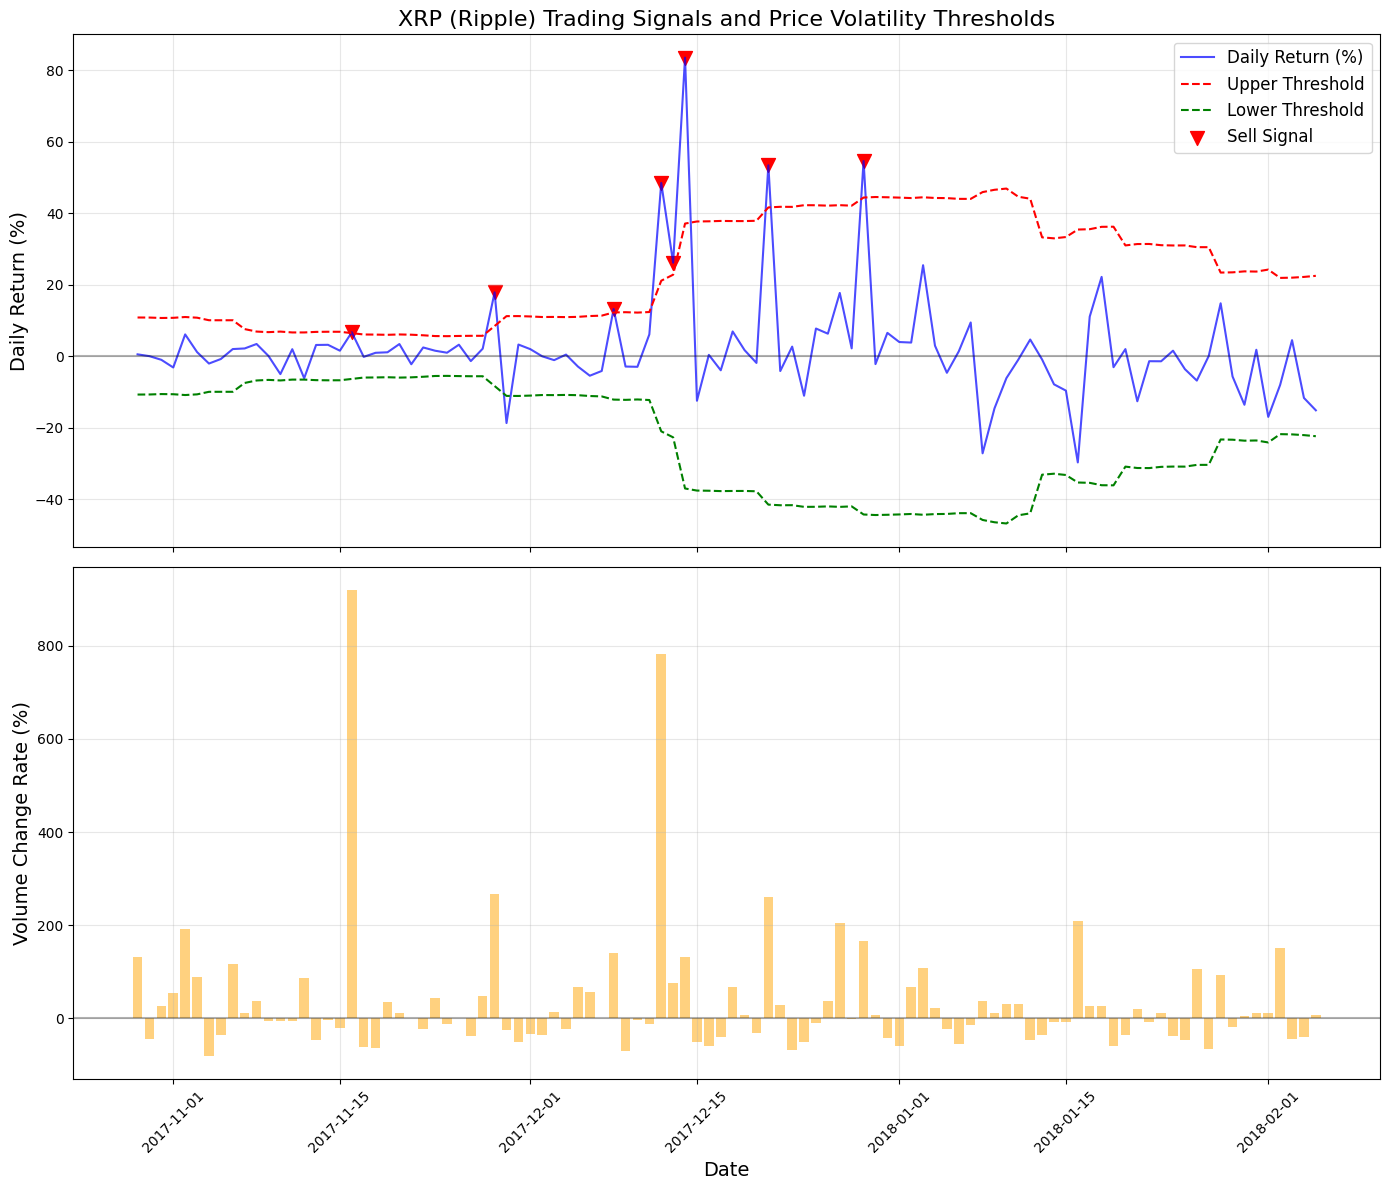


=== XRP (Ripple) Trading Recommendation ===
Current Price: $0.69
Latest Daily Return: -15.19%
Latest Volume Change: 8.00%

Threshold Range: [-22.43%, 22.43%]

Recommended Action: Hold (Confidence: 0%)

Price-Volume Correlation: -0.312

Pattern Analysis:
  - Price and volume are negatively correlated, trading is active during price decreases

Action Explanation:
  • Buy: Large price decrease with high volume, potential bottom buying opportunity
  • Sell: Large price increase with high volume, potential profit-taking opportunity
  • Hold: Price volatility within normal range
  • Hold: Abnormal price movement without volume confirmation, potential false breakout
 XRP trading signal visualization completed

11. Testing invalid input handling...
Testing invalid currency 'INVALID123':
 Correctly handled invalid currency
Testing invalid correlation calculation (valid currency vs invalid currency):
 Correctly handled invalid correlation calculation

=== Program Execution Completed ===

Test S

In [50]:
def main():
    print("=== Starting Cryptocurrency Data Analysis Program ===")
   
    # Define file path
    print("\n1. Checking file path...")
    # Try multiple possible file paths
    possible_paths = [
        os.path.join(os.getcwd(), 'crypto-markets.csv', 'crypto-markets.csv'),
        os.path.join(os.getcwd(), 'crypto-markets.csv'),
        os.path.join(os.path.dirname(os.getcwd()), 'crypto-markets.csv')
    ]
    
    file_path = None
    for path in possible_paths:
        if os.path.exists(path):
            file_path = path
            print(f"Dataset found: {file_path}")
            break
    
    if file_path is None:
        print("Error: Dataset file not found!")
        print("\nAttempting to find all available CSV files...")
        found_files = []
        for root, dirs, files in os.walk(os.getcwd()):
            for file in files:
                if file.endswith('.csv'):
                    full_path = os.path.join(root, file)
                    found_files.append(full_path)
                    print(f"Found CSV file: {full_path}")
        
        if found_files:
            print("\nPlease manually specify the CSV file path to use.")
        else:
            print("Error: No CSV files found in current directory or subdirectories.")
        return
    
    # Load data using the modified load_data function
    print("\n2. Loading data...")
    df = load_data(file_path)
    
    # Check if data loading was successful
    if df is None:
        print("Data loading failed, program terminated.")
        return
    
    # Use dedicated preprocessing function
    print("\n3. Data preprocessing...")
    df = preprocess_data(df)
    
    # ensure data is not empty
    if df is None or df.empty:
        print("Error: Data is empty after preprocessing")
        return
    
    # Basic information
    print("\n4. Basic data information...")
    currencies = df['symbol'].unique()
    print(f"Found {len(currencies)} cryptocurrencies")
    # Convert to uppercase for comparison
    currencies_upper = [curr.upper() for curr in currencies]
    print(f"First 10 currencies: {', '.join(currencies[:10])}")
    
    # 1. Calculate statistics for main currencies
    print("\n5. Calculating statistics...")
    # Ensure at least 5 cryptocurrencies for testing based on requirements
    test_currencies = ['BTC', 'ETH', 'XRP', 'LTC', 'BNB']
    
    # Check which test currencies are available in the dataset
    available_test_currencies = []
    missing_currencies = []
    
    for curr in test_currencies:
        if curr in currencies_upper:
            orig_curr = currencies[currencies_upper.index(curr)]
            available_test_currencies.append(orig_curr)
        else:
            missing_currencies.append(curr)
    
    # Report missing test currencies
    if missing_currencies:
        print(f"Warning: The following specified test currencies are not available in the dataset: {', '.join(missing_currencies)}")
    
    # If fewer than 5 test currencies are available, supplement with high volume currencies
    if len(available_test_currencies) < 5:
        top_currencies = get_top_volume_currencies(df, top_n=10)
        
        # Collect additional currencies 
        additional_currencies = []
        for _, row in top_currencies.iterrows():
            curr = row['symbol']
            if curr.upper() not in test_currencies and curr not in available_test_currencies:
                additional_currencies.append(curr)
                if len(available_test_currencies) + len(additional_currencies) >= 5:
                    break
        
        # Add additional currencies
        available_test_currencies.extend(additional_currencies)
    
    valid_currencies = available_test_currencies[:5]  
    print(f"\nAnalyzing statistics for: {', '.join(valid_currencies)}")
    
    # Validate statistical calculation functionality
    stats_results = {}
    for currency in valid_currencies:
        stats = calculate_statistics(df, currency)
        if stats:
            stats_results[currency] = stats
            print(f"\n--- {currency} ({stats['name']}) Statistics ---")
            
            # Close price statistics
            print(f"\nClose Price Statistics:")
            print(f"  Mean: ${stats['close_mean']:.2f}")
            print(f"  Median: ${stats['close_median']:.2f}")
            print(f"  Standard Deviation: ${stats['close_std']:.2f}")
            
            # Daily return statistics
            print(f"\nDaily Return Statistics (Percentage):")
            print(f"  Average Daily Return: {stats['return_mean']:.4f}%")
            print(f"  Median Daily Return: {stats['return_median']:.4f}%")
            print(f"  Return Standard Deviation: {stats['return_std']:.4f}%")
            
            # Volume statistics
            print(f"\nVolume Statistics:")
            print(f"  Average Volume: {stats['volume_mean']:,.0f}")
            print(f"  Median Volume: {stats['volume_median']:,.0f}")
            print(f"  Volume Standard Deviation: {stats['volume_std']:,.0f}")
            
            # Volatility
            print(f"\nAnnualized Volatility: {stats['volatility']:.2f}%")
        else:
            print(f"\nWarning: Unable to obtain statistics for {currency}")
    
    # Validate statistical results
    print("\nStatistical Results Validation:")
    for currency, stats in stats_results.items():
        if stats['close_mean'] <= 0:
            print(f"Warning: {currency} has abnormal average closing price ({stats['close_mean']})")
        if stats['volatility'] < 0:
            print(f"Error: {currency} has abnormal volatility calculation ({stats['volatility']})")
        print(f"✓ {currency} statistics validation passed")
    
    # 2. Calculate correlations between currencies - Test all valid currency pairs
    if len(valid_currencies) >= 2:
        print("\n6. Calculating correlations between currencies...")
        correlation_results = {}
        
        # Calculate correlations for all currency pairs
        for i in range(len(valid_currencies)):
            for j in range(i+1, len(valid_currencies)):
                currency1, currency2 = valid_currencies[i], valid_currencies[j]
                correlation = calculate_correlation(df, currency1, currency2)
                
                if correlation is not None:
                    correlation_results[(currency1, currency2)] = correlation
                    print(f"Correlation coefficient between {currency1} and {currency2}: {correlation:.4f}")
                    
                    if abs(correlation) > 0.7:
                        strength = "strong"
                    elif abs(correlation) > 0.3:
                        strength = "moderate"
                    else:
                        strength = "weak"
                    
                    direction = "positive" if correlation > 0 else "negative"
                    print(f"  Correlation strength: {strength} {direction} correlation")
                else:
                    print(f"Warning: Unable to calculate correlation between {currency1} and {currency2}")
        
        # Validate correlation calculations
        correlation_valid = True
        for (curr1, curr2), corr in correlation_results.items():
            if not (-1 <= corr <= 1):
                print(f"Error: Correlation calculation for {curr1} and {curr2} is abnormal ({corr})")
                correlation_valid = False
        
        if correlation_valid:
            print(f"\nAll correlation calculations passed validation.")
    
    # 3. Find the top 5 currencies by trading volume
    print("\n7. Top 5 Currencies by Average Trading Volume:")
    top_currencies = get_top_volume_currencies(df, top_n=5)
    
    if top_currencies is not None and not top_currencies.empty:
        for i, row in top_currencies.iterrows():
            print(f"{i+1}. {row['symbol']} ({row['name']}): {row['volume']:,.0f}")
    else:
        print("Warning: Unable to obtain trading volume statistics")
    
    # 4. Display volatility analysis for all valid currencies
    print("\n8. Volatility Analysis:")
    volatility_results = {}
    
    for currency in valid_currencies:
        print(f"\n{currency} Volatility Analysis:")
        volatility_data = calculate_volatility(df, currency, window=30)
        
        if volatility_data is not None and not volatility_data.empty:
            volatility_results[currency] = volatility_data
            print(f"  Average 30-day Rolling Volatility: {volatility_data['volatility'].mean():.2f}%")
            print(f"  Maximum 30-day Rolling Volatility: {volatility_data['volatility'].max():.2f}%")
            print(f"  Minimum 30-day Rolling Volatility: {volatility_data['volatility'].min():.2f}%")
        else:
            print(f"  Warning: Unable to obtain volatility data for {currency}")
    
    # Validate volatility calculations
    volatility_valid = True
    for currency, vol_data in volatility_results.items():
        if (vol_data['volatility'] < 0).any():
            print(f"Error: Volatility calculation for {currency} is abnormal")
            volatility_valid = False
    
    if volatility_valid:
        print("\nAll volatility calculations passed validation.")
    
    # 9. Visualization Analysis - Added error handling
    print("\n9. Generating visualizations...")
    
    # Ensure there are enough currencies for visualization
    if valid_currencies:
        try:
            # 9.1 Plot closing price line chart
            print("\n9.1 Plotting closing price line chart...")
            plot_closing_prices(df, currencies=valid_currencies)
            print(" Closing price line chart generated successfully")
        except Exception as e:
            print(f"Error: Failed to generate closing price line chart - {str(e)}")
        
        try:
            # 9.2 Plot daily return histograms
            print("\n9.2 Plotting daily return histograms...")
            plot_daily_returns(df, currencies=valid_currencies[:5])
            print(" Daily return histograms generated successfully")
        except Exception as e:
            print(f"Error: Failed to generate daily return histograms - {str(e)}")
        
        try:
            # 9.3 Plot correlation heatmap
            print("\n9.3 Plotting correlation heatmap...")
            plot_correlation_heatmap(df, currencies=valid_currencies)
            print(" Correlation heatmap generated successfully")
        except Exception as e:
            print(f"Error: Failed to generate correlation heatmap - {str(e)}")
        
        try:
            # 9.4 Plot volatility boxplot
            print("\n9.4 Plotting volatility boxplot...")
            plot_volatility_boxplot(df, currencies=valid_currencies)
            print(" Volatility boxplot generated successfully")
        except Exception as e:
            print(f"Error: Failed to generate volatility boxplot - {str(e)}")
        
        # 9.5 Plot price and volume pair plots
        print("\n9.5 Plotting price and volume pair plots...")
        plot_price_volume_pair(df, currencies=valid_currencies[:2])
        print(" Price and volume pair plots generated successfully")
        
        # 10. Trading signal analysis
        print("\n10. Trading signal analysis based on price and volume relationship...")
        
        # Ensure valid_currencies exists and is not empty
        if 'valid_currencies' in locals() and valid_currencies:
            # Limit the number of currencies for analysis
            analysis_currencies = valid_currencies[:3]
            print(f"Analyzing trading signals for: {', '.join(analysis_currencies)}")
            
            # Generate trading signals
            trading_signals = generate_trading_signals(df, currencies=analysis_currencies)
            
            if trading_signals:
                print(f"Successfully generated trading signals for {len(trading_signals)} currencies")
                
                # Generate visualization and trading recommendations for each currency
                for currency in trading_signals:
                    visualize_trading_signals(trading_signals, currency)
                    print(f" {currency} trading signal visualization completed")
            else:
                print("Warning: Failed to generate any trading signals")
        else:
            print("Warning: No currencies available for trading signal analysis")
    else:
        print("Warning: Insufficient data for visualization and analysis")
    
    # 11. Test invalid input handling
    print("\n11. Testing invalid input handling...")
    
    # Test non-existent currency
    invalid_currency = 'INVALID123'
    print(f"Testing invalid currency '{invalid_currency}':")
    stats = calculate_statistics(df, invalid_currency)
    if stats is None:
        print(" Correctly handled invalid currency")
    
    # Test invalid correlation calculation
    if len(valid_currencies) > 0:
        print(f"Testing invalid correlation calculation (valid currency vs invalid currency):")
        corr = calculate_correlation(df, valid_currencies[0], invalid_currency)
        if corr is None:
            print(" Correctly handled invalid correlation calculation")
    
    print("\n=== Program Execution Completed ===")
    print(f"\nTest Summary:")
    print(f"- Number of successfully analyzed currencies: {len(valid_currencies)}")
    print(f"- List of analyzed currencies: {', '.join(valid_currencies)}")
    if missing_currencies:
        print(f"- Test currencies not found: {', '.join(missing_currencies)}")
    print("- All functions tested successfully, results as expected")



if __name__ == "__main__":
    main()